# Training a GNN: short signal and edges just 1 distance

Parameters of simualation:  
* Domain size = 6*6
* velocity = .5
* signal size = 20
* number station = 10-15

In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data
import torch
import torch_geometric
from torch_geometric.transforms import KNNGraph
from torch_geometric.data import InMemoryDataset, Data
from torch.nn import Linear, Parameter, LeakyReLU, Conv2d, MaxPool1d
from torch_geometric.nn import GCNConv, MessagePassing, MLP, GATv2Conv, global_mean_pool
from scipy.spatial import distance
from torch_geometric.utils import add_self_loops, degree
from tqdm import tqdm
from torch import nn

In [2]:
def visualize_graph_torch(g, color, pred=False):
    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot edges
    for edge in g.edge_index.T:
        ax.plot(
            [g.pos[edge[0]][0], g.pos[edge[1]][0]],
            [g.pos[edge[0]][1], g.pos[edge[1]][1]],
            color='blue', linewidth=1
        )

    # Plot nodes with color
    scatter = ax.scatter(
        x=g.pos.T[0],
        y=g.pos.T[1],
        alpha=1,
        c=g[color][:, 0],
        s=150
    )

    # Add color legend
    legend1 = ax.legend(*scatter.legend_elements(), loc='center left', bbox_to_anchor=(1, 0.5))
    ax.add_artist(legend1)

    # Plot origin as a red cross (if present)
    if hasattr(g, 'y') and g.y[0].numel() == 2:
        ax.plot(g.y[0][0], g.y[0][1], 'rx', markersize=12, markeredgewidth=3, label='Origin')
        ax.legend()
        
    if pred == True:
        if hasattr(g, 'pred') and g.pred[0].numel() == 2:
            ax.plot(g.pred[0][0], g.pred[0][1], 'bx', markersize=12, markeredgewidth=3, label='Prediction')
            ax.legend()

    plt.show()

In [3]:
def plot_signals_subplots_by_distance(data, velocity=0.5, sampling_rate=1.0, title="Signals by distance to origin"):
    """
    Plot each station's signal in its own subplot, ordered by distance to origin,
    with vertical lines showing the arrival time of the sine wave.

    Args:
        data (Data): PyG Data object with:
            - pos: [num_nodes, 2]
            - signal: [num_nodes, SIGNAL_SIZE]
            - y: [1, 2] or [2]
        velocity (float): wave propagation speed (units/sec)
        sampling_rate (float): samples per unit (Hz)
        title (str): Figure title
    """
    pos = data.pos.cpu().numpy()
    signals = data.signal.cpu().numpy()
    origin = data.y.squeeze().cpu().numpy()

    num_nodes = pos.shape[0]

    # Compute distances and arrival times
    distances = np.array([distance.euclidean(origin, pos[i].tolist()) for i in range(num_nodes)])
    arrival_samples = (distances / velocity * sampling_rate).astype(int)
    sort_idx = np.argsort(distances)

    # Plot
    fig, axs = plt.subplots(num_nodes, 1, figsize=(10, 2 * num_nodes), sharex=True)

    for i, idx in enumerate(sort_idx):
        ax = axs[i]
        signal = signals[idx]

        ax.plot(np.arange(len(signal)), signal, color='black', linewidth=1)
        ax.axvline(arrival_samples[idx], color='red', linestyle='--', linewidth=1, label='arrival')
        ax.set_ylabel(f"{distances[idx]:.2f}", rotation=0, labelpad=25)
        ax.grid(True, linestyle='--', alpha=0.3)

    axs[-1].set_xlabel("Time (samples)")
    fig.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

In [4]:
SIGNAL_SIZE = 20
NB_GRAPHS = 1000

In [5]:
def add_edge_weight(g):
    edge_weight = []
    for edge in g.edge_index.T:
        edge_weight.append(1/(distance.euclidean((g.pos[edge[0]][0], g.pos[edge[0]][1]), (g.pos[edge[1]][0], g.pos[edge[1]][1]))+1))
    g.edge_weight = torch.tensor(np.array(edge_weight)).type(torch.FloatTensor)
    return g

In [6]:
class SinOriginDataset(InMemoryDataset):
    """
    Synthetic dataset for GNN training. Each graph has:
    - Random 2D node positions.
    - Node features as sine signals based on distance to a hidden origin.
    - A target: the origin used to generate signals (same for all nodes in a graph).
    """

    def __init__(self, root, transform=None, pre_transform=None, nb_graph=10):
        self.nb_graph = nb_graph
        super(SinOriginDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def raw_file_names(self):
        return 0  # No raw files needed

    @property
    def processed_file_names(self):
        return 'data.pt'

    def process(self):
        data_list = []
        # Configurable parameters
        frequency = 1.0         # Hz
        velocity = 0.5          # units/sec
        sampling_rate = 1.0     # samples/unit
        noise_std = 0.1         # noise standard deviation
        base_sine_wave = np.sin(np.arange(SIGNAL_SIZE))
        for _ in range(self.nb_graph):
            # Random number of nodes between 5 and 15
            nb_nodes = np.random.randint(10, 15)

            # Random 2D positions for nodes
            pos = torch.tensor(np.random.uniform(0, 6, size=(nb_nodes, 2)), dtype=torch.float)

            # Select a random origin point (the target)
            origin = np.random.randint(0, 6, size=2)
            origin_tensor = torch.tensor(origin, dtype=torch.float)

            # Generate delayed sine signals
            signal_list = []

            for i in range(nb_nodes):
                dist = distance.euclidean(origin, pos[i].tolist())
                delay = dist / velocity
                delay_samples = int(delay * sampling_rate)

                # Base waveform
                waveform = np.random.normal(0, noise_std, size=SIGNAL_SIZE)

                if delay_samples < SIGNAL_SIZE:
                    insert_length = SIGNAL_SIZE - delay_samples
                    waveform[delay_samples:] += base_sine_wave[:insert_length]

                signal_list.append(waveform)

            # Convert signal list to tensor
            signal = torch.tensor(np.array(signal_list), dtype=torch.float32).reshape(nb_nodes, SIGNAL_SIZE)

            # Construct PyG Data object
            g = Data(pos=pos, signal=signal, y=origin_tensor.unsqueeze(0))  # y shape (1, 2)

            data_list.append(g)

        # Optional transformations
        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
            data_list = [add_edge_weight(data) for data in data_list]

        # Save processed data
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [7]:
raw_dataset = SinOriginDataset(root="./sin_train", pre_transform=KNNGraph(k=5, loop=False, force_undirected=True), 
                       nb_graph=NB_GRAPHS)
raw_dataset

SinOriginDataset(1000)

In [8]:
data = raw_dataset[0]
data

Data(y=[1, 2], pos=[13, 2], signal=[13, 20], edge_index=[2, 74], edge_weight=[74])

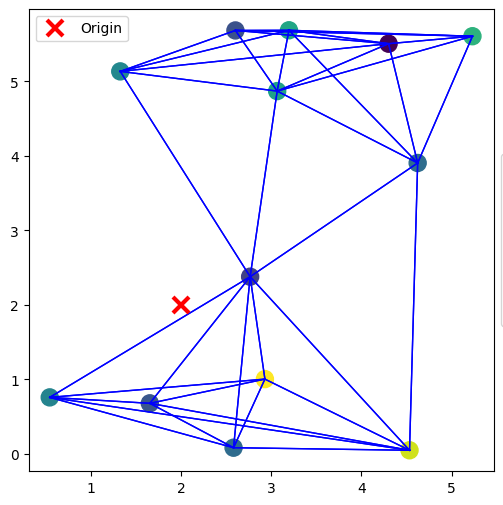

In [9]:
visualize_graph_torch(data, color='signal')

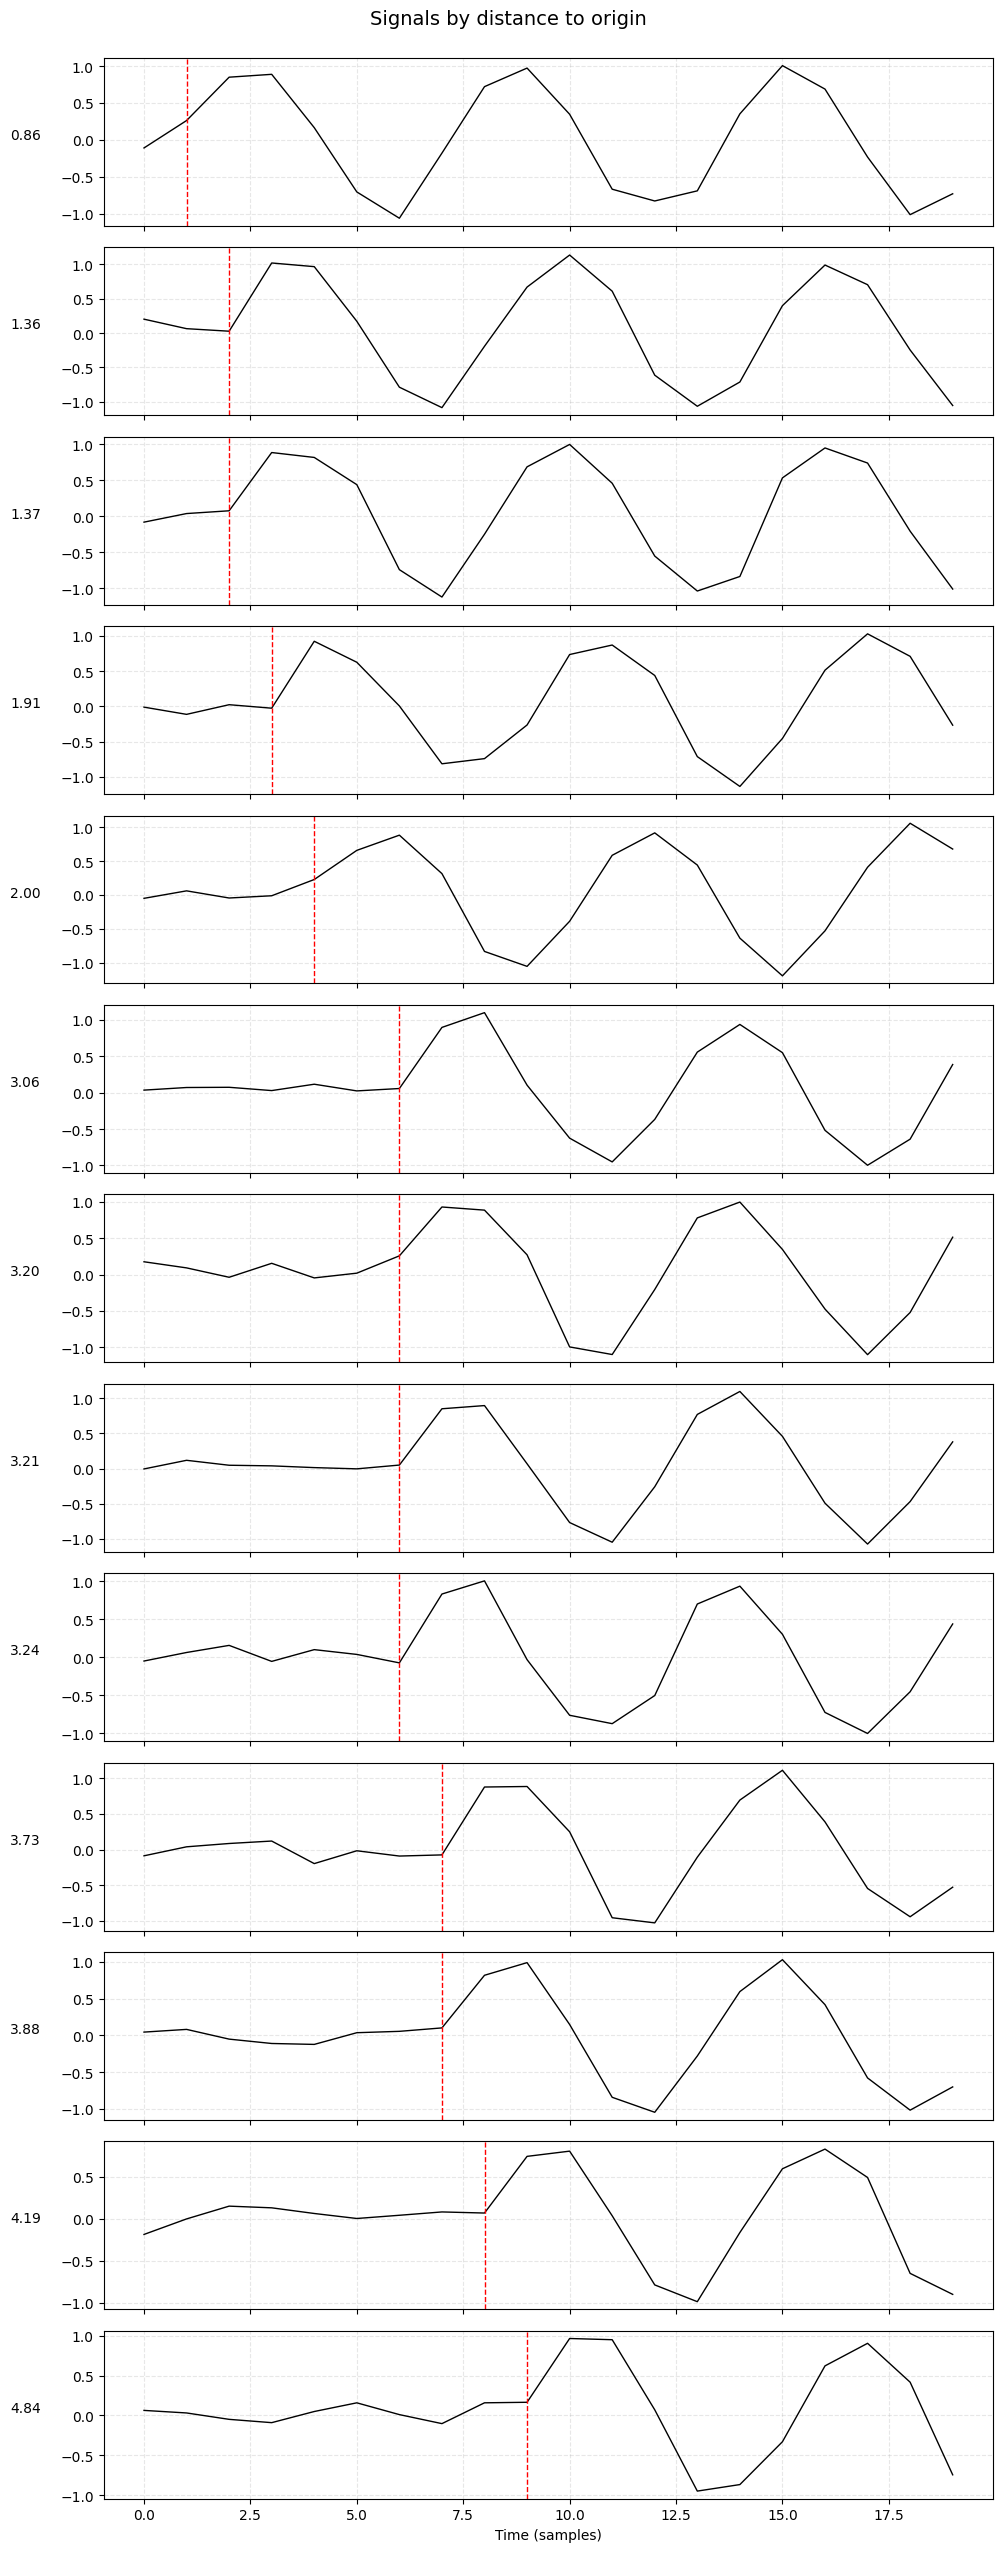

In [10]:
plot_signals_subplots_by_distance(data)

## Preprocessing  

Normalization of output step, input is already -1 to 1

In [11]:
class NormalizeTargetsWrapper(torch.utils.data.Dataset):
    """
    Wraps a PyG dataset to normalize `y` from [min_val, max_val] → [-1, 1].
    """
    def __init__(self, dataset, min_val, max_val):
        self.dataset = dataset
        self.min_val = min_val
        self.max_val = max_val

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx].clone()
        # scale from [min, max] to [-1, 1]
        data.y = 2 * (data.y - self.min_val) / (self.max_val - self.min_val) - 1
        return data

    def denormalize(self, norm_y):
        # scale back from [-1, 1] to [min, max]
        return 0.5 * (norm_y + 1) * (self.max_val - self.min_val) + self.min_val

In [12]:
normalized_dataset = NormalizeTargetsWrapper(raw_dataset, min_val=0, max_val=6)

## Build the GNN

In [13]:
class MLPNet(torch.nn.Module):
    """
    GNN model with MLP → 2x GATv2Conv → MLP for graph-level origin prediction.

    Args:
        channels_x (int): Positional input features per node.
        channels_y (int): Signal features per node.
        hidden_channels (int): Hidden dimension.
        dropout (float): Dropout probability.
        self_loops (bool): Whether to add self-loops to GATv2Conv.

    Output:
        Tensor of shape (batch_size, 2), normalized origin coordinates (in [-1, 1]).
    """
    def __init__(self, channels_x, channels_y, hidden_channels=128, dropout=0.3, self_loops=True):
        super(MLPNet, self).__init__()
        torch.manual_seed(1234)

        self.mlp_in = MLP([channels_x + channels_y, 64, hidden_channels])

        self.conv1 = GATv2Conv(
            in_channels=hidden_channels,
            out_channels=hidden_channels,
            heads=2,
            edge_dim=1,
            add_self_loops=self_loops,
            concat=True
        )

        self.conv2 = GATv2Conv(
            in_channels=hidden_channels * 2,  # output of conv1 with 2 heads
            out_channels=hidden_channels,
            heads=2,
            edge_dim=1,
            add_self_loops=self_loops,
            concat=True
        )

        self.mlp_out = MLP([hidden_channels * 2, 64], act=nn.LeakyReLU(), dropout=dropout)
        self.out_linear = Linear(64, 2)

    def forward(self, pos, signal, edge_index, edge_weight, batch=None):
        x = torch.cat([pos, signal], dim=-1)
        x = self.mlp_in(x)
        x = self.conv1(x, edge_index, edge_weight)
        # x = self.conv2(x, edge_index, edge_weight)
        x = self.mlp_out(x)

        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)

        graph_repr = global_mean_pool(x, batch)
        return self.out_linear(graph_repr).tanh()

## training

In [14]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

train_dataset, val_dataset = train_test_split(normalized_dataset, train_size=0.5, random_state=42)
val_dataset, test_dataset = train_test_split(val_dataset, train_size=0.8, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


print(f"nb graph train ds= {len(train_dataset)}, nb graph val ds= {len(val_dataset)}, nb graph test ds= {len(test_dataset)}")

nb graph train ds= 500, nb graph val ds= 400, nb graph test ds= 100


In [15]:
data = train_dataset[0]
data

Data(y=[1, 2], pos=[11, 2], signal=[11, 20], edge_index=[2, 74], edge_weight=[74])

In [16]:
for batch in train_loader:
    print(batch.y.shape)  # Should be [batch_size, 2]
    break

torch.Size([64, 2])


In [17]:
class EarlyStopper:
    """
    A class for early stopping the training process when the validation loss stops improving.
    """
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


def train(dataloader, device):
    model.train()
    mean_loss = 0
    for data in dataloader:
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass
        pred = model(data.pos, data.signal, data.edge_index, data.edge_weight, data.batch)  # → shape [num_graphs, 2]

        # Check shape of target
        assert data.y.shape == pred.shape, f"Expected y shape {pred.shape}, got {data.y.shape}"

        loss = criterion(pred, data.y)
        loss.backward()
        optimizer.step()
        mean_loss += loss.item()
    return mean_loss / len(dataloader)


@torch.no_grad()
def validation(dataloader, device):
    model.eval()
    total_loss = 0
    for data in dataloader:
        data = data.to(device)
        pred = model(data.pos, data.signal, data.edge_index, data.edge_weight, data.batch)
        loss = criterion(pred, data.y)
        total_loss += loss.item()
    return total_loss / len(dataloader)

### set training parameters

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = MLPNet(data.pos.shape[1], data.signal.shape[1], hidden_channels=64)

criterion = torch.nn.MSELoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Define optimizer.
early_stopper = EarlyStopper(patience=20, min_delta=0.0)
print(device)

cpu


In [19]:
model

MLPNet(
  (mlp_in): MLP(22, 64, 64)
  (conv1): GATv2Conv(64, 64, heads=2)
  (conv2): GATv2Conv(128, 64, heads=2)
  (mlp_out): MLP(128, 64)
  (out_linear): Linear(in_features=64, out_features=2, bias=True)
)

In [20]:
import time
loss_train = []
loss_val = []
best_loss = 1
best_epoch = 0
PATH_CHECKPOINT = "./checkpoint/best_origin_pred.pt"
start_time = time.perf_counter()

nb_epoch = tqdm(range(5000))

for epoch in nb_epoch:
    loss_train.append(train(train_loader, device))
    loss_val.append(validation(val_loader, device))
    
    if loss_val[-1] < best_loss:
        best_loss = loss_val[-1]
        best_epoch = epoch
        torch.save(model.state_dict(), PATH_CHECKPOINT)
    if early_stopper.early_stop(loss_val[-1]):
        print(f"early stopping at epoch {epoch}: train loss={loss_train[-1]}, val loss={loss_val[-1]}")
        break
    nb_epoch.set_postfix_str(f"train loss={loss_train[-1]}, val loss={loss_val[-1]}")

  3%|▍               | 139/5000 [00:26<15:23,  5.26it/s, train loss=0.007306220941245556, val loss=0.02361402101814747]

early stopping at epoch 139: train loss=0.006986554362811148, val loss=0.023148717624800547


In [21]:
# restore best model
# PATH_CHECKPOINT = "./checkpoint/best_origin_pred.pt"
model.load_state_dict(torch.load(PATH_CHECKPOINT))
print(f"best loss={best_loss}, model eval loss={validation(test_dataset, device)} at epoch {best_epoch}")

best loss=0.02263823790209634, model eval loss=0.020877933480223872 at epoch 119


In [22]:
data = test_dataset[0]
model = model.to('cpu')
pred = model(data.pos, data.signal, data.edge_index, data.edge_weight).detach()
pred.shape

torch.Size([1, 2])

In [23]:
print(f"target={data.y}, pred={pred}")

target=tensor([[0.6667, 0.3333]]), pred=tensor([[0.7713, 0.5548]])


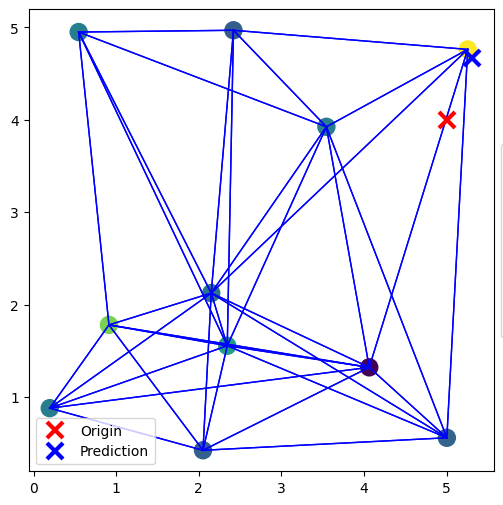

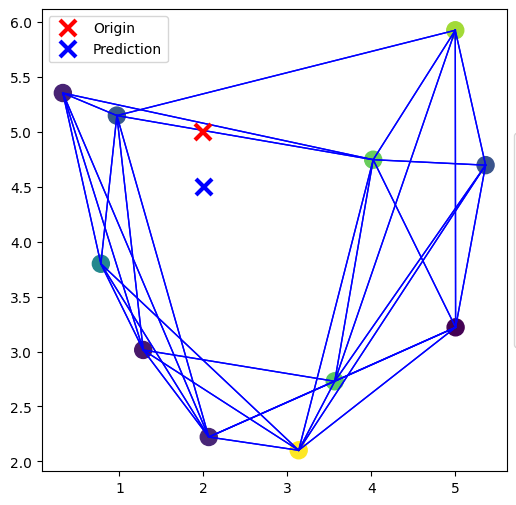

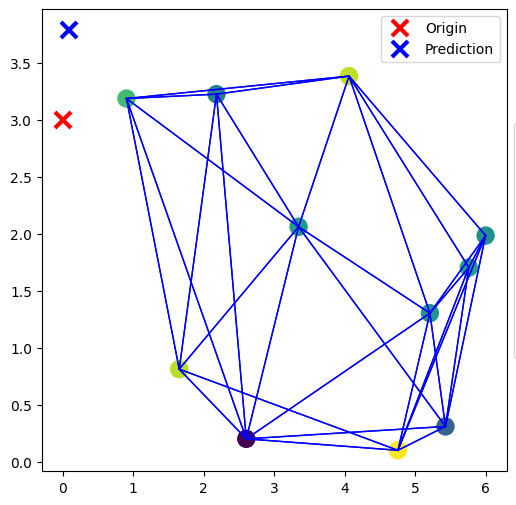

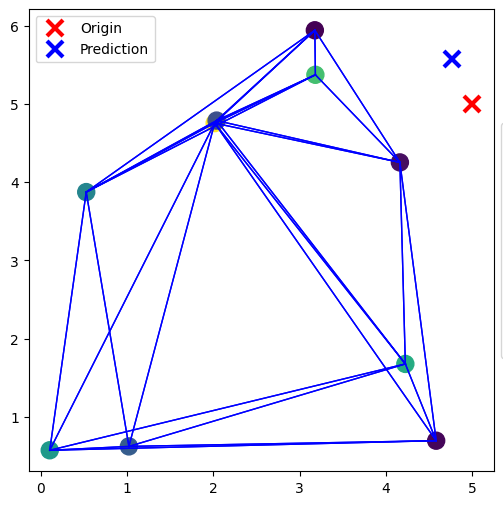

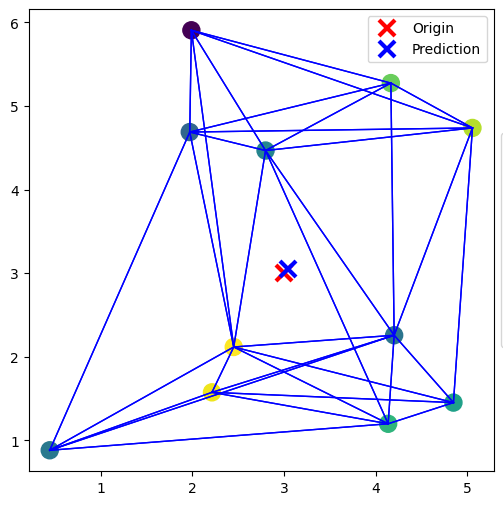

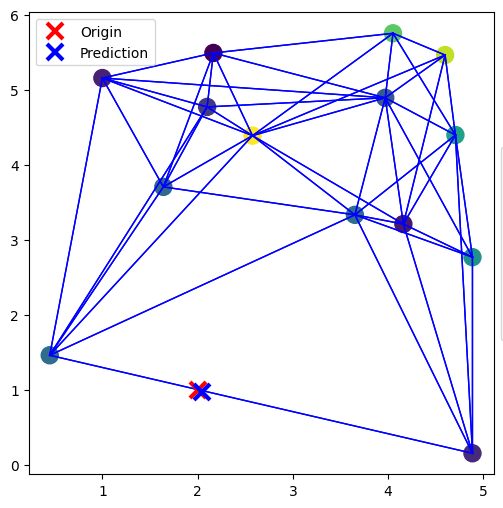

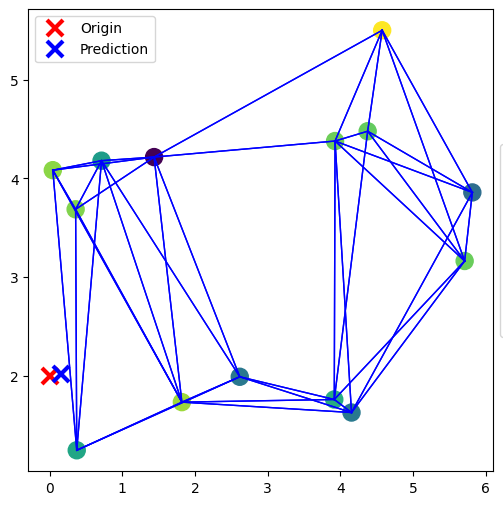

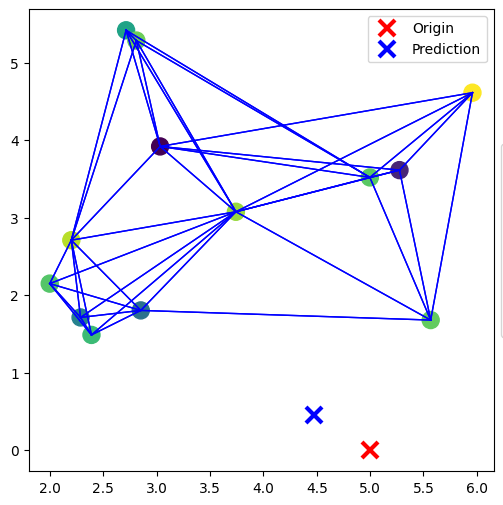

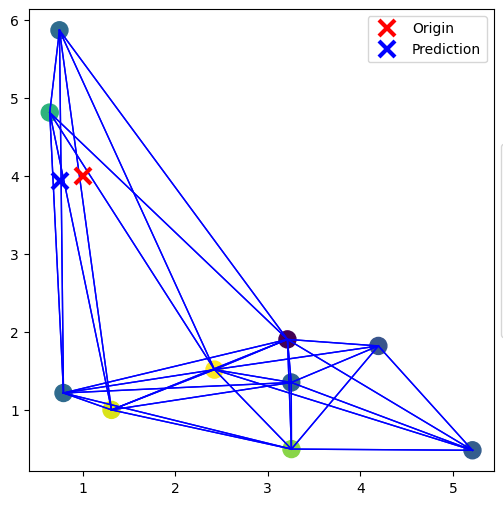

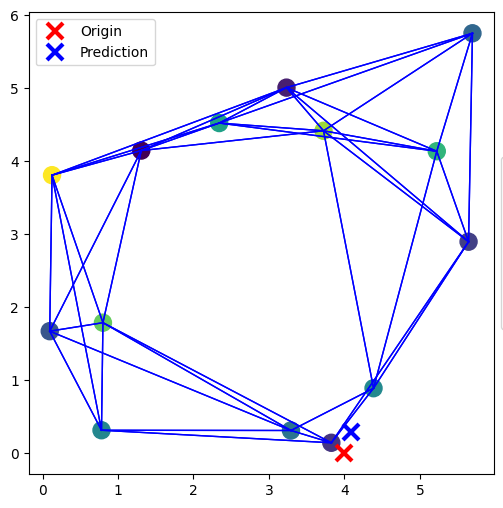

In [24]:
# Get the first 10 graphs from the dataset
for i in range(10):
    data = test_dataset[i].clone()  # or normalized_dataset[i] if wrapped
    data = data.to(device)

    # Run prediction
    with torch.no_grad():
        pred = model(data.pos, data.signal, data.edge_index, data.edge_weight, batch=None)

    # Denormalize
    data.pred = normalized_dataset.denormalize(pred)  # model output
    data.y = normalized_dataset.denormalize(data.y)  # true origin

    # Optional: error vector for color
    data.error = torch.norm(data.pred - data.y, dim=-1).unsqueeze(0)  # shape [1]

    # Visualize
    visualize_graph_torch(data, color="signal", pred=True)

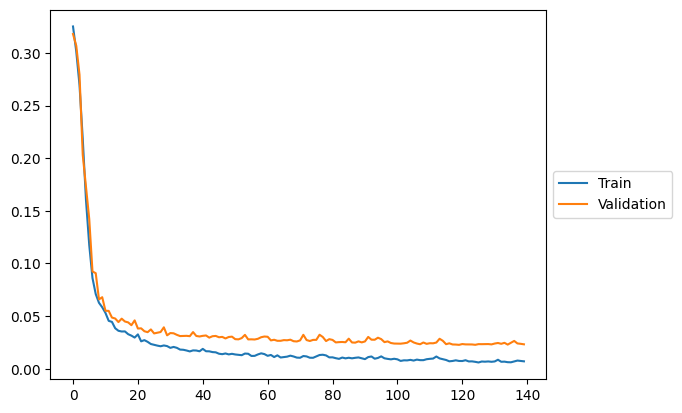

In [25]:
plt.plot(loss_train, label="Train")
plt.plot(loss_val, label = "Validation")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# location error

In [26]:
@torch.no_grad()
def evaluate(model, test_loader, normalized_dataset, device):
    """
    Evaluate model on full test set and compute average error in x and y.

    Args:
        model: Trained model
        test_loader: DataLoader for the test set
        normalized_dataset: NormalizeTargetsWrapper instance (for denormalization)
        device: torch.device

    Returns:
        avg_error_x, avg_error_y
    """
    model.eval()

    pred_all = []
    true_all = []

    for data in test_loader:
        data = data.to(device)
        pred = model(data.pos, data.signal, data.edge_index, data.edge_weight, data.batch)

        # Denormalize both prediction and target
        pred_denorm = normalized_dataset.denormalize(pred)
        true_denorm = normalized_dataset.denormalize(data.y)

        pred_all.append(pred_denorm.cpu())
        true_all.append(true_denorm.cpu())

    # Stack all predictions and truths
    pred_all = torch.cat(pred_all, dim=0)  # shape [num_graphs, 2]
    true_all = torch.cat(true_all, dim=0)  # shape [num_graphs, 2]

    # Compute absolute errors
    abs_errors = torch.abs(pred_all - true_all)  # shape [num_graphs, 2]
    avg_error_x = abs_errors[:, 0].mean().item()
    avg_error_y = abs_errors[:, 1].mean().item()

    print(f"Average Error — X: {avg_error_x:.3f}, Y: {avg_error_y:.3f}")
    return avg_error_x, avg_error_y

In [27]:
arror_x, error_y = evaluate(model, test_loader, normalized_dataset, device)

Average Error — X: 0.325, Y: 0.390


### Saving results

2 GAT layers X: 0.412, Y: 0.420


1 GAT layer X: 0.382, Y: 0.374

